In [1]:
!nvidia-smi

Wed Jul 20 01:19:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.40       Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   57C    P8    11W /  N/A |    982MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import re
import os
import time
import numpy as np
import sklearn
import pandas as pd 
import unicodedata
import tensorflow as tf
import tensorflow.keras as krs
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
import csv

BUFFER_SIZE = 20000
BATCH_SIZE = 32
embedding_dim = 50 # first it was 200

In [3]:
import wandb
wandb.login()
wandb.init(project="gaip-15", entity="chirag1")


wandb: Currently logged in as: chirag1. Use `wandb login --relogin` to force relogin


In [4]:
data_unprocessed_news = pd.read_csv('XLSUM/english_train.csv')
data_unprocessed_news.head()

,Unnamed: 0,id,url,title,summary,text
0,0,uk-wales-56321577,https://www.bbc.com/news/uk-wales-56321577,Weather alert issued for gale force winds in W...,Winds could reach gale force in Wales with sto...,The Met Office has issued a yellow weather war...
1,1,uk-scotland-highlands-islands-11069985,https://www.bbc.com/news/uk-scotland-highlands...,Huge tidal turbine installed at Orkney test site,The massive tidal turbine AK1000 has been inst...,Atlantis Resources unveiled the marine energy ...
2,2,uk-england-leeds-45776523,https://www.bbc.com/news/uk-england-leeds-4577...,Leeds stabbing: Man attacked outside betting shop,A man has been stabbed in broad daylight outsi...,Police were called to the scene outside the Co...
3,3,world-us-canada-51010441,https://www.bbc.com/news/world-us-canada-51010441,Could killing of Iranian general help Trump ge...,It was inevitable that the fallout from the US...,Anthony ZurcherNorth America reporter@awzurche...
4,4,uk-scotland-glasgow-west-52274685,https://www.bbc.com/news/uk-scotland-glasgow-w...,Coronavirus: 'I've moved out to protect my fam...,Week four of social distancing is starting to ...,By Debbie JacksonBBC Scotland But while most o...


In [5]:
from sklearn.utils import shuffle
# shuffling the data 
data_unprocessed_news = shuffle(data_unprocessed_news)
data_unprocessed_news.head()

,Unnamed: 0,id,url,title,summary,text
86396,86396,world-europe-guernsey-56418965,https://www.bbc.com/news/world-europe-guernsey...,Covid-19: Guernsey tourism businesses eligible...,Some Guernsey tourism businesses hit by the co...,"The States said it would help hotels, taxis an..."
268756,268756,technology-51400135,https://www.bbc.com/news/technology-51400135,Xbox says Nintendo and Sony no longer main rivals,Microsoft no longer sees PlayStation-maker Son...,"Phil Spencer, Microsoft's head of gaming, said..."
16181,16181,uk-scotland-north-east-orkney-shetland-37275924,https://www.bbc.com/news/uk-scotland-north-eas...,"Talking Brexit, politics and cake","In the EU referendum vote, Moray narrowly favo...",By David AllisonBBC Scotland News In a coffee ...
242506,242506,education-49785130,https://www.bbc.com/news/education-49785130,Labour would replace 'unfit for purpose' Ofsted,Labour says it would scrap England's education...,Sean CoughlanEducation correspondent@seanjcoug...
202231,202231,world-africa-23788313,https://www.bbc.com/news/world-africa-23788313,Mugabe inauguration: New era or back to old days?,"Hotels in Zimbabwe's capital, Harare, are fill...","By Brian HungweBBC News, Harare About 40 heads..."


In [6]:
summaries, longreview = pd.DataFrame(), pd.DataFrame()
summaries['summary'] = data_unprocessed_news['summary']#[:data_to_use]
longreview['text'] = data_unprocessed_news['text']#[:data_to_use]
(summaries.shape,longreview.shape)

((306522, 1), (306522, 1))

In [7]:
# replacing many abbreviations and lower casing the words
def clean_words(sentence):
    sentence = str(sentence).lower()
    sentence = unicodedata.normalize('NFKD', sentence).encode('ascii', 'ignore').decode('utf-8', 'ignore') # for converting é to e and other accented chars
    sentence = re.sub(r"http\S+","",sentence)
    sentence = re.sub(r"there's", "there is", sentence)
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "that is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    sentence = re.sub(r"'til", "until", sentence)
    sentence = re.sub(r"\"", "", sentence)
    sentence = re.sub(r"\'", "", sentence)
    sentence = re.sub(r' s ', "",sentence)
    sentence = re.sub(r"&39", "", sentence) # the inshorts data has this in it
    sentence = re.sub(r"&34", "", sentence) # the inshorts data has this in it
    sentence = re.sub(r"[\[\]\\0-9()\"$#%/@;:<>{}`+=~|.!?,-]", "", sentence)
    sentence = re.sub(r"&", "", sentence)
    sentence = re.sub(r"\\n", "", sentence)
    sentence = sentence.strip()
    return sentence

In [8]:
summaries['summary'] = summaries['summary'].apply(lambda x: clean_words(x))
longreview['text'] = longreview['text'].apply(lambda x: clean_words(x))

In [9]:
longreview.head()

,text
86396,the states said it would help hotels taxis and...
268756,phil spencer microsofts head of gaming said he...
16181,by david allisonbbc scotland news in a coffee ...
242506,sean coughlaneducation correspondentseanjcough...
202231,by brian hungwebbc news harare about heads of...


In [10]:
# adding start and end token to the senteces of label 
start_token, end_token = '<startseq>' , '<endseq>'
summaries = summaries.apply(lambda x: start_token + ' ' + x + ' ' + end_token)
summaries.head()

,summary
86396,<startseq> some guernsey tourism businesses hi...
268756,<startseq> microsoft no longer sees playstatio...
16181,<startseq> in the eu referendum vote moray nar...
242506,<startseq> labour says it would scrap englands...
202231,<startseq> hotels in zimbabwes capital harare ...


In [11]:
val_split = 0.05
# train validation split
summaries_train = summaries[int(len(summaries)*val_split):]
summaries_val = summaries[:int(len(summaries)*val_split)]
longreview_train = longreview[int(len(summaries)*val_split):]
longreview_val = longreview[:int(len(summaries)*val_split)]

len(longreview_val),len(longreview_train)

(15326, 291196)

In [12]:
longreview_train.iloc[0], summaries_train.iloc[0]

(text    members of the rmt tssa and unite unions have ...
 Name: 124417, dtype: object,
 summary    <startseq> the threat of a uk national rail st...
 Name: 124417, dtype: object)

In [13]:
# because there are senteces with unusually long lengths, 
# we caculate the max length that 95% of sentences are shorter than that
def max_length(summary, text, prct):
    # Create a list of all the captions
    
    length_longs = list(len(d.split()) for d in text)
    length_shorts = list(len(d.split()) for d in summary)

    print('percentile {} of length of news: {}'.format(prct,np.percentile(length_longs, prct)))
    print('longest sentence: ', max(length_longs))
    print()
    print('percentile {} of length of summaries: {}'.format(prct,np.percentile(length_shorts, prct)))
    print('longest sentence: ', max(length_shorts))
    print()
    return int(np.percentile(length_longs, prct)),int(np.percentile(length_shorts, prct))

# selecting sentence length based on the percentile of data that fits in the length
max_len_news, max_len_summary= max_length(summaries_train['summary'].to_list(), longreview_train['text'].to_list(), 90)


print('max-length longreview chosen for training: ', max_len_news)
print('max-length summaries chosen for training: ', max_len_summary)

percentile 90 of length of news: 872.0
longest sentence:  38985

percentile 90 of length of summaries: 31.0
longest sentence:  171

max-length longreview chosen for training:  872
max-length summaries chosen for training:  31


In [14]:
# making a vocabulary of the words 
def create_vocab(summaries, texts = None, minimum_repeat = 3):

    # Create a list of all the captions
    all_captions = []
    for s in summaries:
        all_captions.append(s)

    # Consider only words which occur at least minimum_occurrence times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= minimum_repeat]
    
    vocab = list(set(vocab))
    return vocab

In [15]:
# each word in the vocabulary must be used in the data atleast minimum_repeat times
vocab_dec = create_vocab(summaries_train['summary'].to_list(), minimum_repeat=5) # here we just use the words in vocabulary of summaries
# removing one character words from vocab except for 'a'
for v in vocab_dec:
    if len(v) == 1 and v!='a' and v!='i':
        vocab_dec.remove(v) 
        
vocab_dec = sorted(vocab_dec)[1:] # [1:] is for the '' 
vocab_dec[:10]

['<endseq>',
 '<startseq>',
 'a',
 'a*',
 'a*c',
 'aa',
 'aaa',
 'aaib',
 'aamer',
 'aamir']

In [16]:
# each word in the vocabulary must be used in the data atleast minimum_repeat times
vocab_enc = create_vocab(longreview_train['text'].to_list(), minimum_repeat=3) # here we just use the words in vocabulary of summaries
# removing one character words from vocab except for 'a'
for v in vocab_enc:
    if len(v) == 1 and v!='a' and v!='i':
        vocab_enc.remove(v) 
        
vocab_enc = sorted(vocab_enc)[1:] # [1:] is for the '' 
vocab_enc[:10]

['**',
 '***',
 '****',
 '*****',
 '******',
 '*******',
 '**applicant',
 '**warning',
 '*additional',
 '*all']

In [17]:
oov_token = '<UNK>'
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n' # making sure all the last non digit non alphabet chars are removed
document_tokenizer = krs.preprocessing.text.Tokenizer(filters = filters,oov_token=oov_token)
summary_tokenizer = krs.preprocessing.text.Tokenizer(filters = filters,oov_token=oov_token)
document_tokenizer.fit_on_texts(vocab_enc)
summary_tokenizer.fit_on_texts(vocab_dec)#summaries_train['short'])

# caculating number of words in vocabulary of encoder and decoder
# they are important for positional encoding
encoder_vocab_size = len(document_tokenizer.word_index) + 1 
decoder_vocab_size = len(summary_tokenizer.word_index) + 1

# vocab_size
encoder_vocab_size, decoder_vocab_size

(197638, 29159)

In [18]:
ixtoword_enc = {} # index to word dic
ixtoword_dec = {} # index to word dic

wordtoix_enc = document_tokenizer.word_index # word to index dic
ixtoword_enc[0] = '<PAD0>' # no word in vocab has index 0. but padding is indicated with 0
ixtoword_dec[0] = '<PAD0>' # no word in vocab has index 0. but padding is indicated with 0

for w in document_tokenizer.word_index:
    ixtoword_enc[document_tokenizer.word_index[w]] = w
################################################
wordtoix_dec = summary_tokenizer.word_index # word to index dic

for w in summary_tokenizer.word_index:
    ixtoword_dec[summary_tokenizer.word_index[w]] = w

In [19]:
# assign a number to each word inorder to find it in word embeddings
inputs = document_tokenizer.texts_to_sequences(longreview_train['text'])
targets = summary_tokenizer.texts_to_sequences(summaries_train['summary'])
inputs_val = document_tokenizer.texts_to_sequences(longreview_val['text'])
targets_val = summary_tokenizer.texts_to_sequences(summaries_val['summary'])

In [20]:
inputs = krs.preprocessing.sequence.pad_sequences(inputs, maxlen=max_len_news, padding='post', truncating='post')
targets = krs.preprocessing.sequence.pad_sequences(targets, maxlen=max_len_summary, padding='post', truncating='post')
inputs_val = krs.preprocessing.sequence.pad_sequences(inputs_val, maxlen=max_len_news, padding='post', truncating='post')
targets_val = krs.preprocessing.sequence.pad_sequences(targets_val, maxlen=max_len_summary, padding='post', truncating='post')

In [21]:
# validate train split
dataset = tf.data.Dataset.from_tensor_slices((inputs,targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_val = tf.data.Dataset.from_tensor_slices((inputs_val,targets_val)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [22]:
longreview_val.reset_index(inplace=True, drop=True)
summaries_val.reset_index(inplace=True, drop=True)
longreview_train.reset_index(inplace=True, drop=True)
summaries_train.reset_index(inplace=True, drop=True)

In [23]:
import matplotlib.pyplot as plt

def hist(history):
    plt.title('Loss')

    x= [i[0] for i in history['val']]
    y=[i[1] for i in history['val']]
    plt.plot(x,y,'x-')
    
    x= [i[0] for i in history['train']]
    y=[i[1] for i in history['train']]    
    plt.plot(x,y,'o-')

    plt.legend(['validation','train'])
    plt.show()
    print('smallest val loss:', sorted(history['val'],key=lambda x: x[1])[0])

In [24]:
# the job of this function is to calculate the above equation
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [25]:
class MultiHeadAttention(krs.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads # The dimensions of Q, K, V are called depth

        # the input of these 3 layers are the same: X
        self.wq = krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
        self.wk = krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
        self.wv = krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))

        self.dense = tf.keras.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
    
    # reshape the Q,K,V 
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        # learn the Q,K,V matrices (the layers' weightes)
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        # reshape them
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # the last dens layer expect one vector so we use concat
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights

In [26]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

# The dimension of positional encodings is the same as
# the embeddings (d_model) for facilitating the summation of both.
def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [27]:
 # Making the embedding mtrix
def make_embedding_layer(vocab_len, wordtoix, embedding_dim=200, glove=True, glove_path= ''):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # just a zero matrix 
    else:
        print('Loading glove...')
        glove_dir = glove_path
        embeddings_index = {} 
        f = open(os.path.join(glove_dir, 'glove.6B.'+str(embedding_dim)+'d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        # Get n-dim dense vector for each of the vocab_rocc
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # to import as weights for Keras Embedding layer
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
        
        print("GloVe ",embedding_dim, ' loaded!')

    embedding_layer = Embedding(vocab_len, embedding_dim, mask_zero=True, trainable=False) # we have a limited vocab so we 
                                                                                           # do not train the embedding layer
                                                                                           # we use 0 as padding so => mask_zero=True
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    return embedding_layer

embeddings_encoder = make_embedding_layer(encoder_vocab_size, wordtoix_enc, embedding_dim=embedding_dim, glove=True)
embeddings_decoder = make_embedding_layer(decoder_vocab_size, wordtoix_dec, embedding_dim=embedding_dim, glove=True)

Loading glove...
GloVe  50  loaded!
Loading glove...
GloVe  50  loaded!


In [28]:
# hyper-params
init_lr = 1e-3
lmbda_l2 = 0.1
d_out_rate = 0.1 # tested 0.4, 0.3, 0.1 values this 0.1 seems to be the best
num_layers = 4 # chaged from 4 to 5 to learn better
d_model = embedding_dim # d_model is the representation dimension or embedding dimension of a word (usually in the range 128–512)
dff = 512 # number of neurons in feed forward network
num_heads = 5 # first it was 8 i chenged it to 10 to use embd =300d

In [29]:
# The Point-wise feed-forward network block is essentially a 
# two-layer linear transformation which is used identically throughout the model
def point_wise_feed_forward_network(d_model, dff):
    return krs.Sequential([
        krs.layers.Dense(dff, activation='relu',kernel_regularizer=krs.regularizers.l2(l=lmbda_l2)),
        krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
    ])

In [30]:
class EncoderLayer(krs.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=d_out_rate):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = krs.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = krs.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = krs.layers.Dropout(rate)
        self.dropout2 = krs.layers.Dropout(rate)
   
    # it has 1 layer of multi-headed attention
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [31]:
class DecoderLayer(krs.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=d_out_rate):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = krs.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = krs.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = krs.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = krs.layers.Dropout(rate)
        self.dropout2 = krs.layers.Dropout(rate)
        self.dropout3 = krs.layers.Dropout(rate)
    
    # it has 2 layers of multi-headed attention
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [32]:
class Encoder(krs.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=d_out_rate):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = embeddings_encoder
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = krs.layers.Dropout(rate)
        self.dropout_embd = krs.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x = self.dropout_embd(x, training=training) # dropout added to encoder input changed from nothing to this
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x

In [33]:
class Decoder(krs.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=d_out_rate):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = embeddings_decoder
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)] # a list of decoder layers
        self.dropout = krs.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask) # enc_output is fed into it

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights

In [34]:
class Transformer(krs.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                                     target_vocab_size, pe_input, pe_target, rate=d_out_rate):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = krs.layers.Dense(target_vocab_size, kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
        
        
    # training argument is used in dropout inputs
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
       
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [35]:
transformer = Transformer(
    num_layers, 
    d_model, 
    num_heads, 
    dff,
    encoder_vocab_size, 
    decoder_vocab_size, 
    pe_input=max_len_news,
    pe_target=max_len_summary,
)

In [36]:
# Padding mask for masking "pad" sequences so 
# they won't affect the loss
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

# Lookahead mask for masking future words from
# contributing in prediction of current words in self attention
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [37]:
# this function is use in training step
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
        
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [38]:
lr_schedule = krs.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=init_lr, # originally was 1e-5
    decay_steps=4000, # approximately 5 epochs
    decay_rate=0.95) # originally was 0.9

In [39]:
optimizer2 = Adam(lr_schedule , beta_1=0.9, beta_2=0.98, epsilon=1e-9) # changed to init
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none') # added softmax changed from_logits to false

In [40]:
def loss_function(real, pred, l2= False):
 
    if l2:
        lambda_ = 0.0001
        l2_norms = [tf.nn.l2_loss(v) for v in transformer.trainable_variables]
        l2_norm = tf.reduce_sum(l2_norms)
        l2_value = lambda_ * l2_norm
        loss_ = loss_object(real, pred) + l2_value
    else:
        loss_ = loss_object(real, pred) 
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [41]:
checkpoint_path4 ="checkpoints4"

ckpt4 = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer2)

ckpt_manager4 = tf.train.CheckpointManager(ckpt4, checkpoint_path4, max_to_keep=100)

# if ckpt_manager4.latest_checkpoint:
#     ckpt4.restore(ckpt_manager4.latest_checkpoint)
#     print ('Latest checkpoint restored!!')

In [42]:
def evaluate(input_document):
    input_document = document_tokenizer.texts_to_sequences([input_document])
    input_document = krs.preprocessing.sequence.pad_sequences(input_document, maxlen=max_len_news, 
                                                                           padding='post', truncating='post')
    
    encoder_input = tf.expand_dims(input_document[0], 0)

    decoder_input = [summary_tokenizer.word_index[start_token]]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(max_len_summary):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        # stop prediciting if it reached end_token
        if predicted_id == summary_tokenizer.word_index[end_token]:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)
    return tf.squeeze(output, axis=0), attention_weights

def summarize(input_document):
    # not considering attention weights for now, can be used to plot attention heatmaps in the future
    summarized = evaluate(input_document=input_document)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)  # remove start_token
    return summary_tokenizer.sequences_to_texts(summarized)[0]  # since there is just one translated document

In [43]:
def validate():
    print('validation started ...')
    val_loss.reset_states()
    for (batch, (inp, tar)) in enumerate(dataset_val):    
        tar_inp = tar[:, :-1] # <startseq> hi im moein
        tar_real = tar[:, 1:] # hi im moein <endseq>

        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

        # Operations are recorded if they are executed within this context manager
        # and at least one of their inputs is being "watched". Trainable variables are automatically watched
        predictions, _ = transformer(
            inp, tar_inp, 
            False, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)
        val_loss(loss)
    print('\n* Validation loss: {} '.format(val_loss.result()) )
    return val_loss.result()
# validate()

In [44]:
class CustomModel(tf.Module):
    @tf.function # Compiles a function into a callable TensorFlow graph
    def train_step(inp, tar):
        tar_inp = tar[:, :-1] # <startseq> hi im moein
        tar_real = tar[:, 1:] # hi im moein <endseq>

        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

        # Operations are recorded if they are executed within this context manager
        # and at least one of their inputs is being "watched". Trainable variables are automatically watched
        with tf.GradientTape() as tape:
            predictions, _ = transformer(
                inp, tar_inp, 
                True, 
                enc_padding_mask, 
                combined_mask, 
                dec_padding_mask
            )
            loss = loss_function(tar_real, predictions)

        gradients = tape.gradient(loss, transformer.trainable_variables)    
        optimizer2.apply_gradients(zip(gradients, transformer.trainable_variables))

        # mean the loss with new computed  loss of the step
        train_loss(loss)

In [45]:
history={'val':[],'train':[]}
EPOCHS = 10
not_progressing = 0
# Computes the (weighted) mean of the given loss values.
train_loss = krs.metrics.Mean(name='train_loss')
val_loss = krs.metrics.Mean(name='val_loss')

In [46]:
params = {
'lmbda_l2' : lmbda_l2,
'd_out_rate' :d_out_rate,
'num_layers' : num_layers ,
'd_model' : d_model  ,
'dff' : dff ,
'num_heads' : num_heads,
'init_lr':init_lr}
params

{'lmbda_l2': 0.1,
 'd_out_rate': 0.1,
 'num_layers': 4,
 'd_model': 50,
 'dff': 512,
 'num_heads': 5,
 'init_lr': 0.001}

In [47]:
ep = 1
best_val_loss = np.inf
i1,i2,i3,i4 = np.random.randint(len(summaries_val)),np.random.randint(len(summaries_val)),np.random.randint(len(summaries_val)),np.random.randint(len(summaries_val))

In [48]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [49]:
import os
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
    
else:
    print("No GPU found")

# No GPU found

GPU found


{'lmbda_l2': 0.1, 'd_out_rate': 0.1, 'num_layers': 4, 'd_model': 50, 'dff': 512, 'num_heads': 5, 'init_lr': 0.001}
########################################
Epoch 1 Batch 0 Loss 10.2772
Epoch 1 Batch 150 Loss 7.7776
Epoch 1 Batch 300 Loss 7.3796
Epoch 1 Batch 450 Loss 7.1550
Epoch 1 Batch 600 Loss 6.9830
Epoch 1 Batch 750 Loss 6.8484
Epoch 1 Batch 900 Loss 6.7413
Epoch 1 Batch 1050 Loss 6.6498
Epoch 1 Batch 1200 Loss 6.5712
Epoch 1 Batch 1350 Loss 6.5016
Epoch 1 Batch 1500 Loss 6.4411
Epoch 1 Batch 1650 Loss 6.3853
Epoch 1 Batch 1800 Loss 6.3360
Epoch 1 Batch 1950 Loss 6.2905
Epoch 1 Batch 2100 Loss 6.2487
Epoch 1 Batch 2250 Loss 6.2092
Epoch 1 Batch 2400 Loss 6.1744
Epoch 1 Batch 2550 Loss 6.1418
Epoch 1 Batch 2700 Loss 6.1117
Epoch 1 Batch 2850 Loss 6.0828
Epoch 1 Batch 3000 Loss 6.0546
Epoch 1 Batch 3150 Loss 6.0295
Epoch 1 Batch 3300 Loss 6.0044
Epoch 1 Batch 3450 Loss 5.9815
Epoch 1 Batch 3600 Loss 5.9586
Epoch 1 Batch 3750 Loss 5.9373
Epoch 1 Batch 3900 Loss 5.9174
Epoch 1 Batch 4

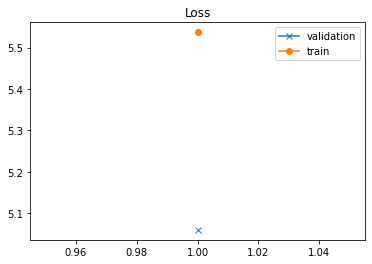

smallest val loss: (1, 5.0600185)
Current Lr:  0.000889859

Time taken for this epoch: 2425.74 secs

Epoch 2 Batch 0 Loss 5.0723
Epoch 2 Batch 150 Loss 5.1359
Epoch 2 Batch 300 Loss 5.1191
Epoch 2 Batch 450 Loss 5.1266
Epoch 2 Batch 600 Loss 5.1230
Epoch 2 Batch 750 Loss 5.1266
Epoch 2 Batch 900 Loss 5.1278
Epoch 2 Batch 1050 Loss 5.1233
Epoch 2 Batch 1200 Loss 5.1237
Epoch 2 Batch 1350 Loss 5.1209
Epoch 2 Batch 1500 Loss 5.1202
Epoch 2 Batch 1650 Loss 5.1178
Epoch 2 Batch 1800 Loss 5.1171
Epoch 2 Batch 1950 Loss 5.1177
Epoch 2 Batch 2100 Loss 5.1160
Epoch 2 Batch 2250 Loss 5.1149
Epoch 2 Batch 2400 Loss 5.1133
Epoch 2 Batch 2550 Loss 5.1110
Epoch 2 Batch 2700 Loss 5.1096
Epoch 2 Batch 2850 Loss 5.1068
Epoch 2 Batch 3000 Loss 5.1062
Epoch 2 Batch 3150 Loss 5.1043
Epoch 2 Batch 3300 Loss 5.1032
Epoch 2 Batch 3450 Loss 5.1022
Epoch 2 Batch 3600 Loss 5.1005
Epoch 2 Batch 3750 Loss 5.0997
Epoch 2 Batch 3900 Loss 5.0991
Epoch 2 Batch 4050 Loss 5.0980
Epoch 2 Batch 4200 Loss 5.0960
Epoch 2 B

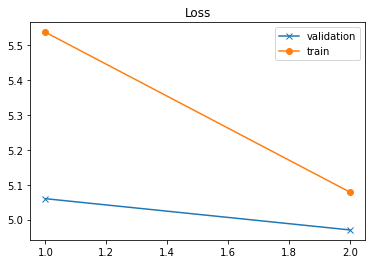

smallest val loss: (2, 4.9705186)
Current Lr:  0.00079184904

Time taken for this epoch: 2379.15 secs

Epoch 3 Batch 0 Loss 5.4419
Epoch 3 Batch 150 Loss 5.0745
Epoch 3 Batch 300 Loss 5.0705
Epoch 3 Batch 450 Loss 5.0593
Epoch 3 Batch 600 Loss 5.0567
Epoch 3 Batch 750 Loss 5.0563
Epoch 3 Batch 900 Loss 5.0553
Epoch 3 Batch 1050 Loss 5.0555
Epoch 3 Batch 1200 Loss 5.0576
Epoch 3 Batch 1350 Loss 5.0570
Epoch 3 Batch 1500 Loss 5.0569
Epoch 3 Batch 1650 Loss 5.0545
Epoch 3 Batch 1800 Loss 5.0528
Epoch 3 Batch 1950 Loss 5.0533
Epoch 3 Batch 2100 Loss 5.0539
Epoch 3 Batch 2250 Loss 5.0532
Epoch 3 Batch 2400 Loss 5.0531
Epoch 3 Batch 2550 Loss 5.0526
Epoch 3 Batch 2700 Loss 5.0513
Epoch 3 Batch 2850 Loss 5.0514
Epoch 3 Batch 3000 Loss 5.0504
Epoch 3 Batch 3150 Loss 5.0499
Epoch 3 Batch 3300 Loss 5.0485
Epoch 3 Batch 3450 Loss 5.0483
Epoch 3 Batch 3600 Loss 5.0486
Epoch 3 Batch 3750 Loss 5.0490
Epoch 3 Batch 3900 Loss 5.0484
Epoch 3 Batch 4050 Loss 5.0484
Epoch 3 Batch 4200 Loss 5.0482
Epoch 3

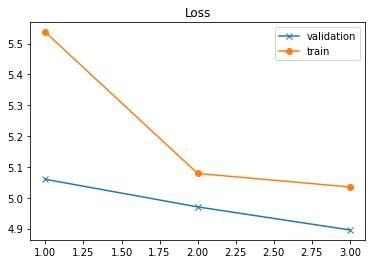

smallest val loss: (3, 4.8958416)
Current Lr:  0.00070463395

Time taken for this epoch: 2389.97 secs

Epoch 4 Batch 0 Loss 5.1332
Epoch 4 Batch 150 Loss 5.0022
Epoch 4 Batch 300 Loss 4.9872
Epoch 4 Batch 450 Loss 4.9884
Epoch 4 Batch 600 Loss 4.9933
Epoch 4 Batch 750 Loss 4.9888
Epoch 4 Batch 900 Loss 4.9897
Epoch 4 Batch 1050 Loss 4.9934
Epoch 4 Batch 1200 Loss 4.9955
Epoch 4 Batch 1350 Loss 4.9968
Epoch 4 Batch 1500 Loss 4.9948
Epoch 4 Batch 1650 Loss 4.9931
Epoch 4 Batch 1800 Loss 4.9903
Epoch 4 Batch 1950 Loss 4.9925
Epoch 4 Batch 2100 Loss 4.9935
Epoch 4 Batch 2250 Loss 4.9916
Epoch 4 Batch 2400 Loss 4.9903
Epoch 4 Batch 2550 Loss 4.9892
Epoch 4 Batch 2700 Loss 4.9903
Epoch 4 Batch 2850 Loss 4.9898
Epoch 4 Batch 3000 Loss 4.9884
Epoch 4 Batch 3150 Loss 4.9879
Epoch 4 Batch 3300 Loss 4.9880
Epoch 4 Batch 3450 Loss 4.9867
Epoch 4 Batch 3600 Loss 4.9869
Epoch 4 Batch 3750 Loss 4.9862
Epoch 4 Batch 3900 Loss 4.9861
Epoch 4 Batch 4050 Loss 4.9857
Epoch 4 Batch 4200 Loss 4.9850
Epoch 4

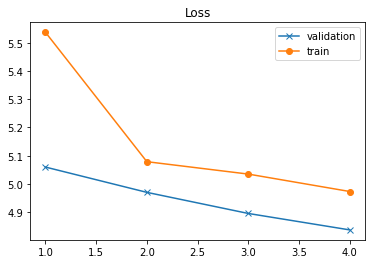

smallest val loss: (4, 4.837661)
Current Lr:  0.00062702486

Time taken for this epoch: 2374.62 secs

Epoch 5 Batch 0 Loss 5.1330
Epoch 5 Batch 150 Loss 4.9424
Epoch 5 Batch 300 Loss 4.9357
Epoch 5 Batch 450 Loss 4.9371
Epoch 5 Batch 600 Loss 4.9410
Epoch 5 Batch 750 Loss 4.9353
Epoch 5 Batch 900 Loss 4.9377
Epoch 5 Batch 1050 Loss 4.9349
Epoch 5 Batch 1200 Loss 4.9371
Epoch 5 Batch 1350 Loss 4.9382
Epoch 5 Batch 1500 Loss 4.9360
Epoch 5 Batch 1650 Loss 4.9369
Epoch 5 Batch 1800 Loss 4.9386
Epoch 5 Batch 1950 Loss 4.9386
Epoch 5 Batch 2100 Loss 4.9388
Epoch 5 Batch 2250 Loss 4.9355
Epoch 5 Batch 2400 Loss 4.9369
Epoch 5 Batch 2550 Loss 4.9363
Epoch 5 Batch 2700 Loss 4.9359
Epoch 5 Batch 2850 Loss 4.9350
Epoch 5 Batch 3000 Loss 4.9340
Epoch 5 Batch 3150 Loss 4.9349
Epoch 5 Batch 3300 Loss 4.9354
Epoch 5 Batch 3450 Loss 4.9345
Epoch 5 Batch 3600 Loss 4.9347
Epoch 5 Batch 3750 Loss 4.9352
Epoch 5 Batch 3900 Loss 4.9355
Epoch 5 Batch 4050 Loss 4.9356
Epoch 5 Batch 4200 Loss 4.9353
Epoch 5 

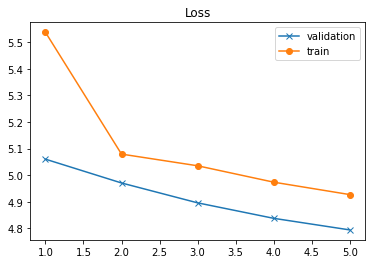

smallest val loss: (5, 4.794109)
Current Lr:  0.0005579637

Time taken for this epoch: 2390.54 secs

Epoch 6 Batch 0 Loss 4.8667
Epoch 6 Batch 150 Loss 4.9173
Epoch 6 Batch 300 Loss 4.9042
Epoch 6 Batch 450 Loss 4.9050
Epoch 6 Batch 600 Loss 4.9027
Epoch 6 Batch 750 Loss 4.9019
Epoch 6 Batch 900 Loss 4.8986
Epoch 6 Batch 1050 Loss 4.8991
Epoch 6 Batch 1200 Loss 4.9014
Epoch 6 Batch 1350 Loss 4.9028
Epoch 6 Batch 1500 Loss 4.9010
Epoch 6 Batch 1650 Loss 4.9032
Epoch 6 Batch 1800 Loss 4.9008
Epoch 6 Batch 1950 Loss 4.9010
Epoch 6 Batch 2100 Loss 4.9008
Epoch 6 Batch 2250 Loss 4.8994
Epoch 6 Batch 2400 Loss 4.8997
Epoch 6 Batch 2550 Loss 4.8997
Epoch 6 Batch 2700 Loss 4.9001
Epoch 6 Batch 2850 Loss 4.9003
Epoch 6 Batch 3000 Loss 4.9008
Epoch 6 Batch 3150 Loss 4.9011
Epoch 6 Batch 3300 Loss 4.9004
Epoch 6 Batch 3450 Loss 4.9000
Epoch 6 Batch 3600 Loss 4.8997
Epoch 6 Batch 3750 Loss 4.8998
Epoch 6 Batch 3900 Loss 4.8988
Epoch 6 Batch 4050 Loss 4.8988
Epoch 6 Batch 4200 Loss 4.8986
Epoch 6 B

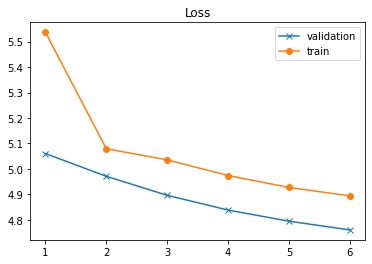

smallest val loss: (6, 4.7597136)
Current Lr:  0.000496509

Time taken for this epoch: 2378.07 secs

Epoch 7 Batch 0 Loss 4.9181
Epoch 7 Batch 150 Loss 4.8833
Epoch 7 Batch 300 Loss 4.8629
Epoch 7 Batch 450 Loss 4.8689
Epoch 7 Batch 600 Loss 4.8699
Epoch 7 Batch 750 Loss 4.8679
Epoch 7 Batch 900 Loss 4.8714
Epoch 7 Batch 1050 Loss 4.8701
Epoch 7 Batch 1200 Loss 4.8796
Epoch 7 Batch 1350 Loss 4.8769
Epoch 7 Batch 1500 Loss 4.8788
Epoch 7 Batch 1650 Loss 4.8736
Epoch 7 Batch 1800 Loss 4.8722
Epoch 7 Batch 1950 Loss 4.8753
Epoch 7 Batch 2100 Loss 4.8756
Epoch 7 Batch 2250 Loss 4.8738
Epoch 7 Batch 2400 Loss 4.8734
Epoch 7 Batch 2550 Loss 4.8747
Epoch 7 Batch 2700 Loss 4.8741
Epoch 7 Batch 2850 Loss 4.8734
Epoch 7 Batch 3000 Loss 4.8737
Epoch 7 Batch 3150 Loss 4.8742
Epoch 7 Batch 3300 Loss 4.8731
Epoch 7 Batch 3450 Loss 4.8726
Epoch 7 Batch 3600 Loss 4.8736
Epoch 7 Batch 3750 Loss 4.8739
Epoch 7 Batch 3900 Loss 4.8732
Epoch 7 Batch 4050 Loss 4.8733
Epoch 7 Batch 4200 Loss 4.8724
Epoch 7 B

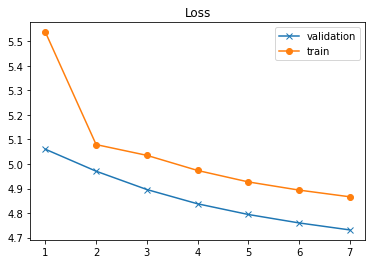

smallest val loss: (7, 4.731229)
Current Lr:  0.000441823

Time taken for this epoch: 2406.19 secs

Epoch 8 Batch 0 Loss 4.6570
Epoch 8 Batch 150 Loss 4.8626
Epoch 8 Batch 300 Loss 4.8686
Epoch 8 Batch 450 Loss 4.8522
Epoch 8 Batch 600 Loss 4.8466
Epoch 8 Batch 750 Loss 4.8501
Epoch 8 Batch 900 Loss 4.8529
Epoch 8 Batch 1050 Loss 4.8509
Epoch 8 Batch 1200 Loss 4.8525
Epoch 8 Batch 1350 Loss 4.8532
Epoch 8 Batch 1500 Loss 4.8499
Epoch 8 Batch 1650 Loss 4.8487
Epoch 8 Batch 1800 Loss 4.8487
Epoch 8 Batch 1950 Loss 4.8473
Epoch 8 Batch 2100 Loss 4.8491
Epoch 8 Batch 2250 Loss 4.8505
Epoch 8 Batch 2400 Loss 4.8499
Epoch 8 Batch 2550 Loss 4.8502
Epoch 8 Batch 2700 Loss 4.8488
Epoch 8 Batch 2850 Loss 4.8460
Epoch 8 Batch 3000 Loss 4.8445
Epoch 8 Batch 3150 Loss 4.8450
Epoch 8 Batch 3300 Loss 4.8473
Epoch 8 Batch 3450 Loss 4.8467
Epoch 8 Batch 3600 Loss 4.8470
Epoch 8 Batch 3750 Loss 4.8475
Epoch 8 Batch 3900 Loss 4.8479
Epoch 8 Batch 4050 Loss 4.8475
Epoch 8 Batch 4200 Loss 4.8479
Epoch 8 Ba

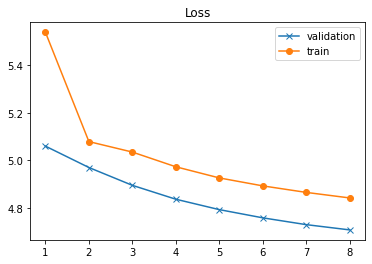

smallest val loss: (8, 4.709178)
Current Lr:  0.00039316015

Time taken for this epoch: 2507.25 secs

Epoch 9 Batch 0 Loss 4.7757
Epoch 9 Batch 150 Loss 4.8133
Epoch 9 Batch 300 Loss 4.8354
Epoch 9 Batch 450 Loss 4.8301
Epoch 9 Batch 600 Loss 4.8267
Epoch 9 Batch 750 Loss 4.8233
Epoch 9 Batch 900 Loss 4.8260
Epoch 9 Batch 1050 Loss 4.8258
Epoch 9 Batch 1200 Loss 4.8297
Epoch 9 Batch 1350 Loss 4.8325
Epoch 9 Batch 1500 Loss 4.8314
Epoch 9 Batch 1650 Loss 4.8306
Epoch 9 Batch 1800 Loss 4.8292
Epoch 9 Batch 1950 Loss 4.8284
Epoch 9 Batch 2100 Loss 4.8283
Epoch 9 Batch 2250 Loss 4.8272
Epoch 9 Batch 2400 Loss 4.8253
Epoch 9 Batch 2550 Loss 4.8241
Epoch 9 Batch 2700 Loss 4.8246
Epoch 9 Batch 2850 Loss 4.8252
Epoch 9 Batch 3000 Loss 4.8255
Epoch 9 Batch 3150 Loss 4.8256
Epoch 9 Batch 3300 Loss 4.8265
Epoch 9 Batch 3450 Loss 4.8265
Epoch 9 Batch 3600 Loss 4.8260
Epoch 9 Batch 3750 Loss 4.8268
Epoch 9 Batch 3900 Loss 4.8260
Epoch 9 Batch 4050 Loss 4.8259
Epoch 9 Batch 4200 Loss 4.8250
Epoch 9 

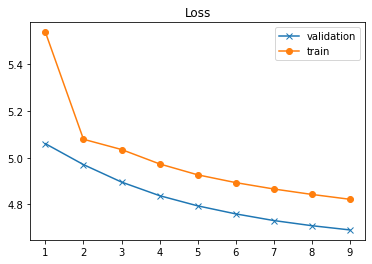

smallest val loss: (9, 4.691053)
Current Lr:  0.00034985712

Time taken for this epoch: 2401.28 secs

Epoch 10 Batch 0 Loss 4.7530
Epoch 10 Batch 150 Loss 4.7934
Epoch 10 Batch 300 Loss 4.7893
Epoch 10 Batch 450 Loss 4.7890
Epoch 10 Batch 600 Loss 4.7971
Epoch 10 Batch 750 Loss 4.7984
Epoch 10 Batch 900 Loss 4.8006
Epoch 10 Batch 1050 Loss 4.8031
Epoch 10 Batch 1200 Loss 4.8001
Epoch 10 Batch 1350 Loss 4.8019
Epoch 10 Batch 1500 Loss 4.8047
Epoch 10 Batch 1650 Loss 4.8054
Epoch 10 Batch 1800 Loss 4.8071
Epoch 10 Batch 1950 Loss 4.8083
Epoch 10 Batch 2100 Loss 4.8102
Epoch 10 Batch 2250 Loss 4.8085
Epoch 10 Batch 2400 Loss 4.8075
Epoch 10 Batch 2550 Loss 4.8071
Epoch 10 Batch 2700 Loss 4.8069
Epoch 10 Batch 2850 Loss 4.8061
Epoch 10 Batch 3000 Loss 4.8053
Epoch 10 Batch 3150 Loss 4.8061
Epoch 10 Batch 3300 Loss 4.8061
Epoch 10 Batch 3450 Loss 4.8071
Epoch 10 Batch 3600 Loss 4.8054
Epoch 10 Batch 3750 Loss 4.8053
Epoch 10 Batch 3900 Loss 4.8051
Epoch 10 Batch 4050 Loss 4.8045
Epoch 10 Ba

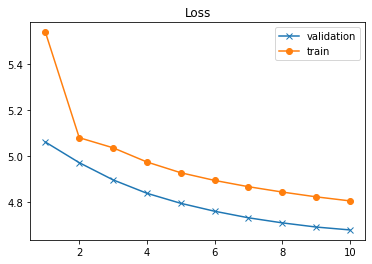

smallest val loss: (10, 4.6784816)
Current Lr:  0.00031132347

Time taken for this epoch: 2405.90 secs



In [50]:
print(params)
print('#'*40)

for epoch in range(ep,EPOCHS+1):
    ep = epoch
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        
        CustomModel.train_step(inp, tar)
    
        if batch % 150 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch , batch, train_loss.result()))
                  
    print()
    print(summarize(clean_words(longreview_val['text'][i1])))
    print(summarize(clean_words(longreview_val['text'][i2])))
    print(summarize(clean_words(longreview_val['text'][i3])))
    print(summarize(clean_words(longreview_val['text'][i4])))
    print()

    val_loss_ = validate().numpy()
    history['val'].append((epoch,val_loss_))
    print ('\n* Train Loss {:.4f}'.format(train_loss.result()))
    history['train'].append((epoch,train_loss.result().numpy()))


    if best_val_loss-val_loss_ > 0.1:
        ckpt_save_path4 = ckpt_manager4.save()
        print ('\nSaving checkpoint for epoch {} at {}'.format(epoch, ckpt_save_path4))  
        best_val_loss = val_loss_

    hist(history)
    print('Current Lr: ',optimizer2._decayed_lr('float32').numpy())
    print ('\nTime taken for this epoch: {:.2f} secs\n'.format(time.time() - start))
    print('='*40)
    
    train_l=train_loss.result()

    wandb.log({'epochs': epoch,
                   'loss': np.mean(train_l),
                   'val_loss': np.mean(val_loss_)})

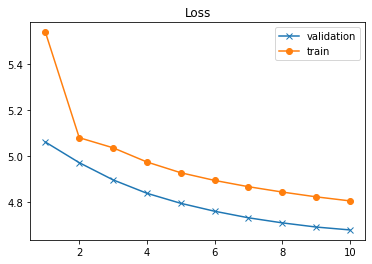

smallest val loss: (10, 4.6784816)


{'lmbda_l2': 0.1,
 'd_out_rate': 0.1,
 'num_layers': 4,
 'd_model': 50,
 'dff': 512,
 'num_heads': 5,
 'init_lr': 0.001}

In [51]:
hist(history)
params

In [52]:
model=CustomModel()
tf.saved_model.save(model, 'export1')

INFO:tensorflow:Assets written to: export1\assets


INFO:tensorflow:Assets written to: export1\assets


In [53]:
print(clean_words(longreview_val['text'][i1]))
print()
print(summarize(clean_words(longreview_val['text'][i1])))

by katie prescottbusiness correspondent he has run the michelinstarred pied a terre in central london for  years it took just days to close the restaurants doors when the coronavirus lockdown was introduced now like many other businesses mr moore wants clarity about what restrictions might be in place when his restaurant can start serving again next week the government will release a series of papers outlining how it intends to get the uk economy up and running again once the pandemic passes research by business groups show that companies overwhelmingly want to get back to work as soon as possible and want information on how to do so for mr moore that means finding out things like will there be a quota on the number of people i can let in per square foot will there be rules about distances between tables reopening will not be a quick process his staff are on furlough he will have to reconnect with his suppliers and write a new pareddown menu that does not require too many chefs in the 

In [54]:
print(clean_words(longreview_val['text'][i2]))
print()
print(summarize(clean_words(longreview_val['text'][i2])))

the environment agency issued its severe warning for portreath following heavy rainfall across the south west the environment agency said evacuation plans had been drawn up for portreath there are still flood warnings and flood alerts in place across cornwall devon somerset dorset and wiltshire paul gainey from the environment agency said staff were initially unable to unblock a drainage gate in portreath which meant the water built up and built up in the road near the tunnel he said the agency had anticipated flooding in up to  homes in portreath and that the police had drawn up evacuation plans however a mechanical claw device was used to unblock the screen by  gmt on saturday causing the water to drain and no one was evacuated in cornwall two properties were also flooded in angarrack and three properties in blackwater new warnings warnings of flooding for cornwall devon and somerset have now all been downgraded from a medium risk to a low risk however new flood warnings have been is

In [55]:
model.summary()

AttributeError: 'CustomModel' object has no attribute 'summary'